# Chest X-Ray Classification
In this sample project, we will build a convolutional neural network to classify [the Chest X-Ray Data set from Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).<br>
We begin with importing the matplotlib, numpy, os, tensorflow, keras and PIL.

In [1]:
import matplotlib
from matplotlib import pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [2]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [3]:
import os

In [4]:
from PIL import Image

print( Image.__version__ )

5.4.1


In [5]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [6]:
import keras
from keras import models
from keras import layers
from keras import callbacks



print( keras.__version__ )

2.2.4


Using TensorFlow backend.


Now, we have a first look at the data.

In [7]:
path_train_normal = "C:\\Users\\rhopi\\OneDrive\\Desktop\\kaggle data 1\\x ray data set\\chest_xray\\train\\NORMAL\\"

path_train_pneumonia = "C:\\Users\\rhopi\\OneDrive\\Desktop\\kaggle data 1\\x ray data set\\chest_xray\\train\\PNEUMONIA\\"

path_test_normal = "C:\\Users\\rhopi\\OneDrive\\Desktop\\kaggle data 1\\x ray data set\\chest_xray\\test\\NORMAL\\"

path_test_pneumonia = "C:\\Users\\rhopi\\OneDrive\\Desktop\\kaggle data 1\\x ray data set\\chest_xray\\test\\PNEUMONIA\\"

In [8]:
train_images_normal = os.listdir( path_train_normal )

train_images_pneumonia = os.listdir( path_train_pneumonia )

test_images_normal = os.listdir( path_test_normal )

test_images_pneumonia = os.listdir( path_test_pneumonia )

([], <a list of 0 Text yticklabel objects>)

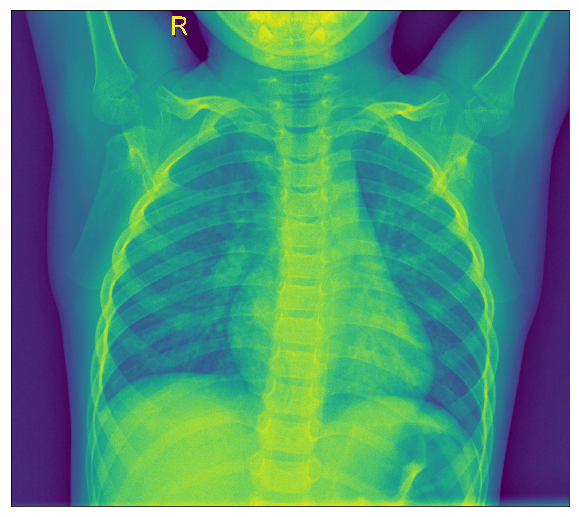

In [9]:
plt.figure( figsize = ( 10, 10 ) )

plt.imshow( Image.open( path_train_normal + train_images_normal[ 0 ] ) )

plt.xticks( [] )

plt.yticks( [] )

Since we do not know, whether all images have the same format, we now open all images in order to extract their height and width. We then create a scatterplot to find out, whether they all have the same height and width or not.

In [10]:
height = []

width = []

colors = []

number_of_train_images_normal = 0

number_of_train_images_pneumonia = 0

number_of_test_images_normal = 0

number_of_test_images_pneumonia = 0

In [11]:
for image in train_images_normal:
    
    h, w = Image.open( path_train_normal + image ).size
    
    c = Image.open( path_train_normal + image ).mode
    
    number_of_train_images_normal = number_of_train_images_normal + 1
    
    height.append( h )
    
    width.append( w )
    
    colors.append( c )

In [12]:
for image in train_images_pneumonia:
    
    h, w = Image.open( path_train_pneumonia + image ).size
    
    c = Image.open( path_train_pneumonia + image ).mode
    
    number_of_train_images_pneumonia = number_of_train_images_pneumonia + 1
    
    height.append( h )
    
    width.append( w )
    
    colors.append( c )

In [13]:
for image in test_images_normal:
    
    h, w = Image.open( path_test_normal + image ).size
    
    c = Image.open( path_test_normal + image ).mode
    
    number_of_test_images_normal = number_of_test_images_normal + 1
    
    height.append( h )
    
    width.append( w )
    
    colors.append( c )

In [14]:
for image in test_images_pneumonia:
    
    h, w = Image.open( path_test_pneumonia + image ).size
    
    c = Image.open( path_test_pneumonia + image ).mode
    
    number_of_test_images_pneumonia = number_of_test_images_pneumonia + 1
    
    height.append( h )
    
    width.append( w )
    
    colors.append( c )

Text(0, 0.5, 'Height')

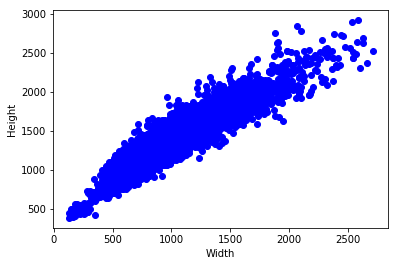

In [15]:
plt.plot( width, height, "bo" )

plt.xlabel( "Width" )

plt.ylabel( "Height" )

From the plot above, we can read, that the images have many different resolutions.<br>
Since we have many different resolutions, we try the following: we scale each image to $200*200$ pixels and fill the missing parts with black pixels. This way, we do not scale images up, and thereby introduce new information into small images. However, the larger images will lose information.<br>
Let's find out about the colors.

In [16]:
print( np.unique( colors ) )

['L' 'RGB']


This means, that we have greyscale images ("L"), and color images ("RGB"). When we rescale the images, we also transform all images into greyscale.

In [17]:
def image_transformer( path ):
    """
        Open the image from path.
        Transform this image - if necessary - to greyscale.
        Rescale this image to 200 * 200 pixels.
        Return the resulting matrix.
    """
    
    image = Image.open( path )
    
    if image.mode == "RGB":
        
        image = image.convert( "L" )
    
    image.thumbnail( ( 200, 200 ), Image.ANTIALIAS )
    
    h, w = image.size
    
    numpy_image = np.array( image )
    
    return_image = np.zeros( [ 200, 200 ] )
    
    return_image[ 0 : w, 0 : h ] = numpy_image
    
    return return_image

Before we continue, let's have a look at how many training data are available for each class:

In [18]:
print( "Number of normal training data : " + str( number_of_train_images_normal ) )

print( "Number of Pneumonia training data : " + str( number_of_train_images_pneumonia ) )

Number of normal training data : 1341
Number of Pneumonia training data : 3875


In [19]:
train_normal_data = np.zeros( [ number_of_train_images_normal, 200, 200, 1 ] )

train_pneumonia_data = np.zeros( [ number_of_train_images_pneumonia, 200, 200, 1 ] )

test_normal_data = np.zeros( [ number_of_test_images_normal, 200, 200, 1 ] )

test_pneumonia_data = np.zeros( [ number_of_test_images_pneumonia, 200, 200, 1 ] )

In [20]:
train_normal_aim = np.zeros( [ number_of_train_images_normal, 1 ] ) + 1.0

train_pneumonia_aim = np.zeros( [ number_of_train_images_pneumonia, 1 ] )

test_normal_aim = np.zeros( [ number_of_test_images_normal, 1 ] ) + 1.0

test_pneumonia_aim = np.zeros( [ number_of_test_images_pneumonia, 1 ] )

Since we discovered an imbalance between the two classes, we introduce a weighing for each class:

In [21]:
weight_of_normal_data = ( np.float( number_of_train_images_normal + number_of_train_images_pneumonia ) / np.float( number_of_train_images_normal ) ) / 2.0

weight_of_pneumonia_data = ( np.float( number_of_train_images_normal + number_of_train_images_pneumonia ) / np.float( number_of_train_images_pneumonia ) ) / 2.0

class_weight = { 1 : weight_of_normal_data, 0 : weight_of_pneumonia_data }

Now let's fill the arrays with the data:

In [22]:
i = 0

for image in train_images_normal:
    
    train_normal_data[ i, :, :, 0 ] = image_transformer( path_train_normal + image )
    
    i = i + 1

In [23]:
i = 0

for image in train_images_pneumonia:
    
    train_pneumonia_data[ i, :, :, 0 ] = image_transformer( path_train_pneumonia + image )
    
    i = i + 1

In [24]:
i = 0

for image in test_images_normal:
    
    test_normal_data[ i, :, :, 0 ] = image_transformer( path_test_normal + image )
    
    i = i + 1

In [25]:
i = 0

for image in test_images_pneumonia:
    
    test_pneumonia_data[ i, :, :, 0 ] = image_transformer( path_test_pneumonia + image )
    
    i = i + 1

Now we have transformed the original images into greyscale image and rescaled them. Let's have a look at them.

([], <a list of 0 Text yticklabel objects>)

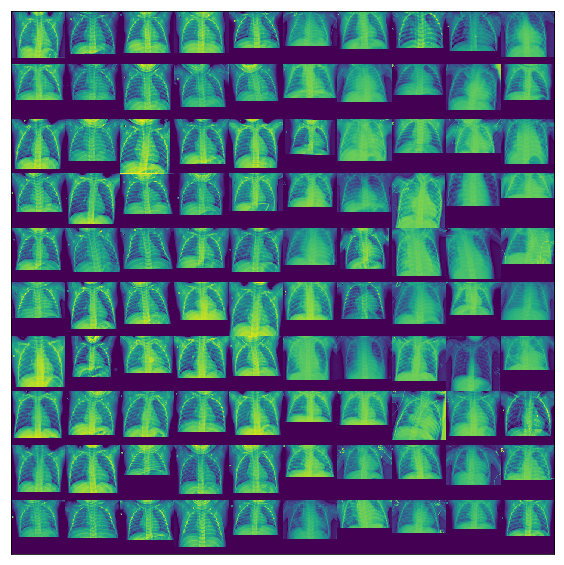

In [26]:
plotmatrix = np.zeros( [ 2000, 2000 ] )





for i in range( 10 ):
    
    for j in range( 5 ):
        
        up = i * 200
        
        down = up + 200
        
        left = j * 200
        
        right = left + 200
        
        plotmatrix[ up : down, left : right ] = train_normal_data[ i * 5 + j, :, :, 0 ]
        
        
        
 
for i in range( 10 ):
    
    for j in range( 5 ):
        
        up = i * 200
        
        down = up + 200
        
        left = 5 * 200 + j * 200
        
        right = left + 200
        
        plotmatrix[ up : down, left : right ] = train_pneumonia_data[ i * 5 + j, :, :, 0 ]
        
        
        
        
        
plt.figure( figsize = ( 10, 10 ) )

plt.imshow( plotmatrix )

plt.xticks( [] )

plt.yticks( [] )

Now we combine the normal data and the pneumonia data.

In [27]:
x_train = np.concatenate( ( train_normal_data, train_pneumonia_data ) )

y_train = np.concatenate( ( train_normal_aim, train_pneumonia_aim ) )

x_test = np.concatenate( ( test_normal_data, test_pneumonia_data ) )

y_test = np.concatenate( ( test_normal_aim, test_pneumonia_aim ) )

Now, we normalize the data.

In [28]:
mu = np.mean( x_train )

std = np.std( x_train )




x_train = ( x_train - mu ) / std

xmax = np.max( x_train )

xmin = np.min( x_train )




x_test = ( x_test - mu ) / std

x_test = np.clip( x_test, xmin, xmax )

Now that we have prepared the data, we construct the neural network.

In [29]:
x = keras.engine.input_layer.Input( shape = ( 200, 200, 1, ) )




layer1 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_1_Filter_1" )( x )

layer2 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_1_Filter_2" )( layer1 )

layer3 = layers.MaxPooling2D( name = "Model_1_Filter_3" )( layer2 )

layer4 = layers.Dropout( 0.3, name = "Model_1_Filter_4" )( layer3 )

layer5 = layers.BatchNormalization( name = "Model_1_Filter_5" )( layer4 )

layer6 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_1_Filter_6" )( layer5 )

layer7 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_1_Filter_7" )( layer6 )

layer8 = layers.MaxPooling2D( name = "Model_1_Filter_8" )( layer7 )

layer9 = layers.Dropout( 0.3, name = "Model_1_Filter_9" )( layer8 )

layer10 = layers.BatchNormalization( name = "Model_1_Filter_10" )( layer9 )

layer11 = layers.Flatten( name = "Model_1_Filter_11" )( layer10 )

output = layers.Dense( 1, activation = "sigmoid", name = "Model_1_Output" )( layer11 )




model1 = keras.Model( x, output )

model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\rhopi\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
Model_1_Filter_1 (Conv2D)    (None, 196, 196, 64)      1664      
_________________________________________________________________
Model_1_Filter_2 (Conv2D)    (None, 192, 192, 64)      102464    
_________________________________________________________________
Model_1_Filter_3 (MaxPooling (None, 96, 96, 64)        0         
_________________________________________________________________
Model_1_Filter_4 (Dropout)   (None, 96, 96, 64)        0         
_________________________________________________________________
Model_1_Filter_5 (BatchNorma (None, 96, 96, 64)        256       
_________________________________________________________________
Model_1_Filter_6 (Conv2D)    (None, 92, 92, 64)        102464    
__________

In [30]:
model1.compile( optimizer = keras.optimizers.SGD( lr = 0.0001, momentum = 0.9, decay = 0, nesterov = False ), 
              loss = "binary_crossentropy", metrics = [ "accuracy" ] )

In [31]:
history1 = model1.fit( x_train, y_train, epochs = 20, batch_size = 20, validation_data = ( x_test, y_test ),
                   class_weight = class_weight, shuffle = True )

Instructions for updating:
Use tf.cast instead.
Train on 5216 samples, validate on 624 samples
Epoch 1/20
5216/5216 [==============================] - 41s 8ms/step - loss: 0.2348 - acc: 0.9018 - val_loss: 1.8834 - val_acc: 0.6410
Epoch 2/20
5216/5216 [==============================] - 35s 7ms/step - loss: 0.1494 - acc: 0.9431 - val_loss: 1.8877 - val_acc: 0.6651
Epoch 3/20
5216/5216 [==============================] - 35s 7ms/step - loss: 0.1170 - acc: 0.9578 - val_loss: 1.7847 - val_acc: 0.6779
Epoch 4/20
5216/5216 [==============================] - 35s 7ms/step - loss: 0.1005 - acc: 0.9626 - val_loss: 1.3817 - val_acc: 0.7260
Epoch 5/20
5216/5216 [==============================] - 35s 7ms/step - loss: 0.0867 - acc: 0.9668 - val_loss: 1.8881 - val_acc: 0.6619
Epoch 6/20
5216/5216 [==============================] - 36s 7ms/step - loss: 0.0863 - acc: 0.9655 - val_loss: 1.6397 - val_acc: 0.6859
Epoch 7/20
5216/5216 [==============================] - 36s 7ms/step - loss: 0.0691 - acc: 0.97

Text(0, 0.5, 'Loss (-)')

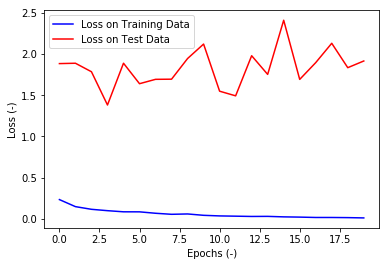

In [32]:
plt.plot( history1.history[ "loss" ], "b", label = "Loss on Training Data" )

plt.plot( history1.history[ "val_loss" ], "r", label = "Loss on Test Data" )

plt.legend( loc = "best" )

plt.xlabel( "Epochs (-)" )

plt.ylabel( "Loss (-)" )

Text(0, 0.5, 'Accuracy (-)')

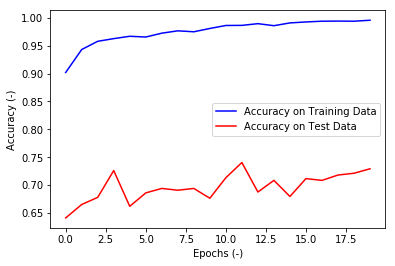

In [33]:
plt.plot( history1.history[ "acc" ], "b", label = "Accuracy on Training Data" )

plt.plot( history1.history[ "val_acc" ], "r", label = "Accuracy on Test Data" )

plt.legend( loc = "best" )

plt.xlabel( "Epochs (-)" )

plt.ylabel( "Accuracy (-)" )

We notice, that the model performs well on the __training__ data, but mediocre on the __test__ data. This is a clear sign of __overfitting__. We can combat __overfitting__ by reducing the complexity of the network and by adding additional noise. We start with crippling the network.

In [34]:
x = keras.engine.input_layer.Input( shape = ( 200, 200, 1, ) )




layer1 = layers.Conv2D( 16, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_2_Filter_1" )( x )

layer2 = layers.Conv2D( 16, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_2_Filter_2" )( layer1 )

layer3 = layers.MaxPooling2D( name = "Model_2_Filter_3" )( layer2 )

layer4 = layers.Dropout( 0.3, name = "Model_2_Filter_4" )( layer3 )

layer5 = layers.BatchNormalization( name = "Model_2_Filter_5" )( layer4 )

layer6 = layers.Conv2D( 16, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_2_Filter_6" )( layer5 )

layer7 = layers.Conv2D( 16, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_2_Filter_7" )( layer6 )

layer8 = layers.MaxPooling2D( name = "Model_2_Filter_8" )( layer7 )

layer9 = layers.Dropout( 0.3, name = "Model_2_Filter_9" )( layer8 )

layer10 = layers.BatchNormalization( name = "Model_2_Filter_10" )( layer9 )

layer11 = layers.Flatten( name = "Model_2_Filter_11" )( layer10 )

output = layers.Dense( 1, activation = "sigmoid", name = "Model_2_Output" )( layer11 )




model2 = keras.Model( x, output )

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
Model_2_Filter_1 (Conv2D)    (None, 196, 196, 16)      416       
_________________________________________________________________
Model_2_Filter_2 (Conv2D)    (None, 192, 192, 16)      6416      
_________________________________________________________________
Model_2_Filter_3 (MaxPooling (None, 96, 96, 16)        0         
_________________________________________________________________
Model_2_Filter_4 (Dropout)   (None, 96, 96, 16)        0         
_________________________________________________________________
Model_2_Filter_5 (BatchNorma (None, 96, 96, 16)        64        
_________________________________________________________________
Model_2_Filter_6 (Conv2D)    (None, 92, 92, 16)        6416      
__________

In [35]:
model2.compile( optimizer = keras.optimizers.SGD( lr = 0.0001, momentum = 0.9, decay = 0, nesterov = False ), 
              loss = "binary_crossentropy", metrics = [ "accuracy" ] )

In [36]:
history2 = model2.fit( x_train, y_train, epochs = 20, batch_size = 20, validation_data = ( x_test, y_test ),
                   class_weight = class_weight, shuffle = True )

Train on 5216 samples, validate on 624 samples
Epoch 1/20
5216/5216 [==============================] - 12s 2ms/step - loss: 0.3097 - acc: 0.8597 - val_loss: 1.1163 - val_acc: 0.6651
Epoch 2/20
5216/5216 [==============================] - 10s 2ms/step - loss: 0.1850 - acc: 0.9222 - val_loss: 1.3920 - val_acc: 0.6554
Epoch 3/20
5216/5216 [==============================] - 10s 2ms/step - loss: 0.1465 - acc: 0.9402 - val_loss: 1.2887 - val_acc: 0.6795
Epoch 4/20
5216/5216 [==============================] - 10s 2ms/step - loss: 0.1315 - acc: 0.9465 - val_loss: 1.0310 - val_acc: 0.7212
Epoch 5/20
5216/5216 [==============================] - 10s 2ms/step - loss: 0.1241 - acc: 0.9515 - val_loss: 1.0798 - val_acc: 0.6987
Epoch 6/20
5216/5216 [==============================] - 10s 2ms/step - loss: 0.1040 - acc: 0.9574 - val_loss: 1.0840 - val_acc: 0.7212
Epoch 7/20
5216/5216 [==============================] - 10s 2ms/step - loss: 0.1002 - acc: 0.9595 - val_loss: 1.3026 - val_acc: 0.6843
Epoch 8/

Text(0, 0.5, 'Loss (-)')

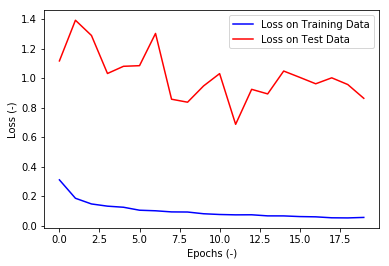

In [37]:
plt.plot( history2.history[ "loss" ], "b", label = "Loss on Training Data" )

plt.plot( history2.history[ "val_loss" ], "r", label = "Loss on Test Data" )

plt.legend( loc = "best" )

plt.xlabel( "Epochs (-)" )

plt.ylabel( "Loss (-)" )

Text(0, 0.5, 'Accuracy (-)')

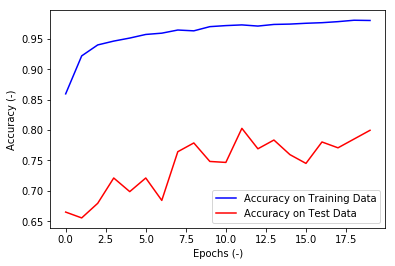

In [38]:
plt.plot( history2.history[ "acc" ], "b", label = "Accuracy on Training Data" )

plt.plot( history2.history[ "val_acc" ], "r", label = "Accuracy on Test Data" )

plt.legend( loc = "best" )

plt.xlabel( "Epochs (-)" )

plt.ylabel( "Accuracy (-)" )

The crippling reduced the accuracy on the __training__ data a little, and and a little accuracy was gained on the __test__ data. We do not want to further cripple the network since we want to achieve a good performance on the __training__ data. Therefore, our only way to improve the performance on the __test__ data is to introduce regularization.

In [39]:
x = keras.engine.input_layer.Input( shape = ( 200, 200, 1, ) )




layer1 = layers.Conv2D( 16, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_3_Filter_1" )( x )

layer2 = layers.Conv2D( 16, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_3_Filter_2" )( layer1 )

layer3 = layers.MaxPooling2D( name = "Model_3_Filter_3" )( layer2 )

layer4 = layers.Dropout( 0.3, name = "Model_3_Filter_4" )( layer3 )

layer5 = layers.BatchNormalization( name = "Model_3_Filter_5" )( layer4 )

layer6 = layers.Conv2D( 16, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_3_Filter_6" )( layer5 )

layer7 = layers.Conv2D( 16, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "valid", 
                       name = "Model_3_Filter_7" )( layer6 )

layer8 = layers.MaxPooling2D( name = "Model_3_Filter_8" )( layer7 )

layer9 = layers.Dropout( 0.3, name = "Model_3_Filter_9" )( layer8 )

layer10 = layers.BatchNormalization( name = "Model_3_Filter_10" )( layer9 )

layer11 = layers.Flatten( name = "Model_3_Filter_11" )( layer10 )

layer12 = layers.Dense( 512, activation = layers.LeakyReLU( alpha = 0.3 ), name = "Model_3_Filter_12" )( layer11 )

layer13 = layers.Dropout( 0.3, name = "Model_3_Filter_13" )( layer12 )

layer14 = layers.BatchNormalization( name = "Model_3_Filter_14" )( layer13 )

output = layers.Dense( 1, activation = "sigmoid", name = "Model_3_Output" )( layer14 )




model3 = keras.Model( x, output )

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
Model_3_Filter_1 (Conv2D)    (None, 196, 196, 16)      416       
_________________________________________________________________
Model_3_Filter_2 (Conv2D)    (None, 192, 192, 16)      6416      
_________________________________________________________________
Model_3_Filter_3 (MaxPooling (None, 96, 96, 16)        0         
_________________________________________________________________
Model_3_Filter_4 (Dropout)   (None, 96, 96, 16)        0         
_________________________________________________________________
Model_3_Filter_5 (BatchNorma (None, 96, 96, 16)        64        
_________________________________________________________________
Model_3_Filter_6 (Conv2D)    (None, 92, 92, 16)        6416      
__________

In [40]:
model3.compile( optimizer = keras.optimizers.SGD( lr = 0.0001, momentum = 0.9, decay = 0, nesterov = False ), 
              loss = "binary_crossentropy", metrics = [ "accuracy" ] )

In [41]:
history3 = model3.fit( x_train, y_train, epochs = 50, batch_size = 20, validation_data = ( x_test, y_test ),
                   class_weight = class_weight, shuffle = True )

Train on 5216 samples, validate on 624 samples
Epoch 1/50
5216/5216 [==============================] - 13s 2ms/step - loss: 0.3933 - acc: 0.7958 - val_loss: 0.6157 - val_acc: 0.7244
Epoch 2/50
5216/5216 [==============================] - 12s 2ms/step - loss: 0.2836 - acc: 0.8497 - val_loss: 0.5782 - val_acc: 0.7596
Epoch 3/50
5216/5216 [==============================] - 12s 2ms/step - loss: 0.2467 - acc: 0.8785 - val_loss: 1.2261 - val_acc: 0.6603
Epoch 4/50
5216/5216 [==============================] - 12s 2ms/step - loss: 0.2300 - acc: 0.8888 - val_loss: 0.6259 - val_acc: 0.7548
Epoch 5/50
5216/5216 [==============================] - 12s 2ms/step - loss: 0.2075 - acc: 0.8995 - val_loss: 1.0449 - val_acc: 0.6715
Epoch 6/50
5216/5216 [==============================] - 12s 2ms/step - loss: 0.1939 - acc: 0.9082 - val_loss: 0.7402 - val_acc: 0.7244
Epoch 7/50
5216/5216 [==============================] - 12s 2ms/step - loss: 0.1796 - acc: 0.9124 - val_loss: 0.4969 - val_acc: 0.7965
Epoch 8/

Text(0, 0.5, 'Loss (-)')

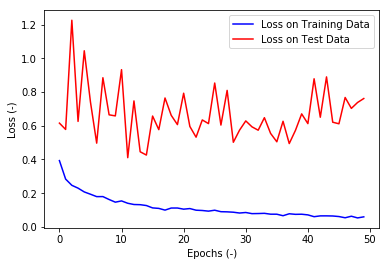

In [42]:
plt.plot( history3.history[ "loss" ], "b", label = "Loss on Training Data" )

plt.plot( history3.history[ "val_loss" ], "r", label = "Loss on Test Data" )

plt.legend( loc = "best" )

plt.xlabel( "Epochs (-)" )

plt.ylabel( "Loss (-)" )

Text(0, 0.5, 'Accuracy (-)')

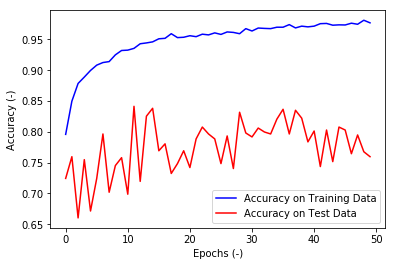

In [43]:
plt.plot( history3.history[ "acc" ], "b", label = "Accuracy on Training Data" )

plt.plot( history3.history[ "val_acc" ], "r", label = "Accuracy on Test Data" )

plt.legend( loc = "best" )

plt.xlabel( "Epochs (-)" )

plt.ylabel( "Accuracy (-)" )

The regularization introduced by the dense layer and the following dropout layer helped reduce the loss on the __test__ data. But this also worsened the quality of the predictions on the __training__ data which is why, we had to extend the number of epochs for training. We could further finetune the model by introducing additional dropout layers and training longer, but for now, we stop here.